Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

**We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.**

In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0
x_train.shape

(60000, 28, 28)

In [3]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


In [4]:
len(x_train[0])

784

In [5]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


In [6]:
x_test[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     



```
# Ce texte est au format code
```




#  **First AutoEncoder**

In [7]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Let's also create a separate encoder model:
this model maps an input to its encoded representation


In [8]:
encoder = Model(input_img, encoded)

As well as the decoder model:

In [9]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [10]:
autoencoder.compile(optimizer='adam', loss='mse')

In [11]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0687 - val_loss: 0.0406
Epoch 2/20
235/235 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0288
Epoch 3/20
235/235 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.0227
Epoch 4/20
235/235 [==============================] - 0s 1ms/step - loss: 0.0211 - val_loss: 0.0190
Epoch 5/20
235/235 [==============================] - 0s 1ms/step - loss: 0.0181 - val_loss: 0.0166
Epoch 6/20
235/235 [==============================] - 0s 1ms/step - loss: 0.0160 - val_loss: 0.0148
Epoch 7/20
235/235 [==============================] - 0s 1ms/step - loss: 0.0144 - val_loss: 0.0135
Epoch 8/20
235/235 [==============================] - 0s 1ms/step - loss: 0.0133 - val_loss: 0.0124
Epoch 9/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0124 - val_loss: 0.0117
Epoch 10/20
235/235 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0112

We can try to visualize the reconstructed inputs and the encoded representationslib.

In [12]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 300us/step


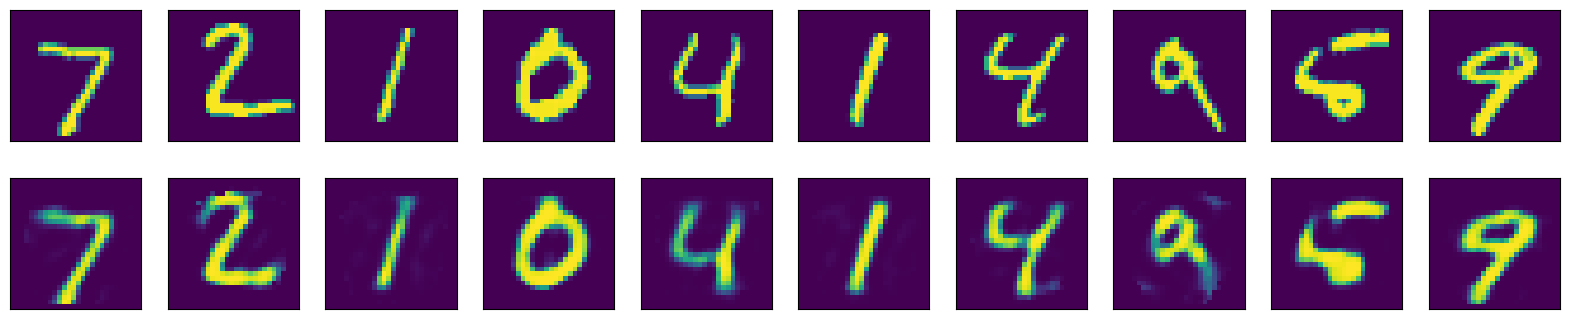

In [13]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# **Sparse AutoEncoder**




In [16]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)

decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

In [17]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

encoder = Model(input_img, encoded)

In [18]:
autoencoder.compile(optimizer='nadam', loss='mse')


In [19]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 1s 2ms/step - loss: 0.0738 - val_loss: 0.0452
Epoch 2/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0342
Epoch 3/50
235/235 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0287
Epoch 4/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0253
Epoch 5/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0228
Epoch 6/50
235/235 [==============================] - 0s 1ms/step - loss: 0.0222 - val_loss: 0.0210
Epoch 7/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0207 - val_loss: 0.0197
Epoch 8/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0196 - val_loss: 0.0189
Epoch 9/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0188 - val_loss: 0.0181
Epoch 10/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0182 - val_loss: 0.0175

In [20]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 316us/step


In [21]:
encoded_imgs[0]

array([0.        , 1.1225111 , 0.        , 0.64662516, 2.1646469 ,
       0.68791246, 0.24598837, 0.14329064, 0.        , 0.5496154 ,
       0.22003874, 0.        , 1.0213358 , 0.7336358 , 0.6260259 ,
       0.41190454, 1.5009726 , 0.61102235, 0.31470662, 2.8669133 ,
       0.29116166, 0.4643044 , 0.6229886 , 0.34374174, 0.29712293,
       0.48212665, 0.32812342, 1.2658916 , 0.        , 1.4408852 ,
       0.5584708 , 0.23183498], dtype=float32)

In [22]:

print(sum(encoded_imgs[0]==0))
print(sum(decoded_imgs[0]==0))


5
0


313/313 [==============================] - 0s 245us/step


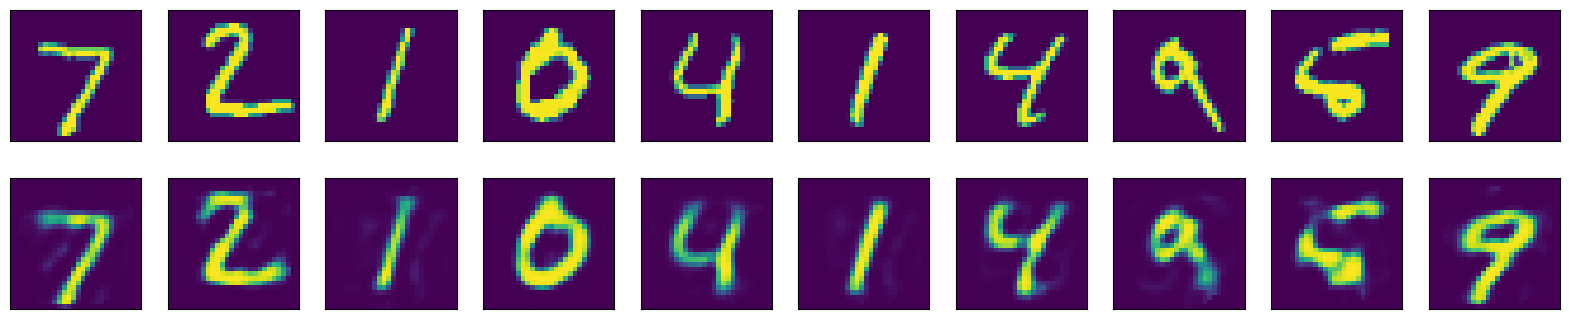

In [23]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()



313/313 [==============================] - 0s 256us/step


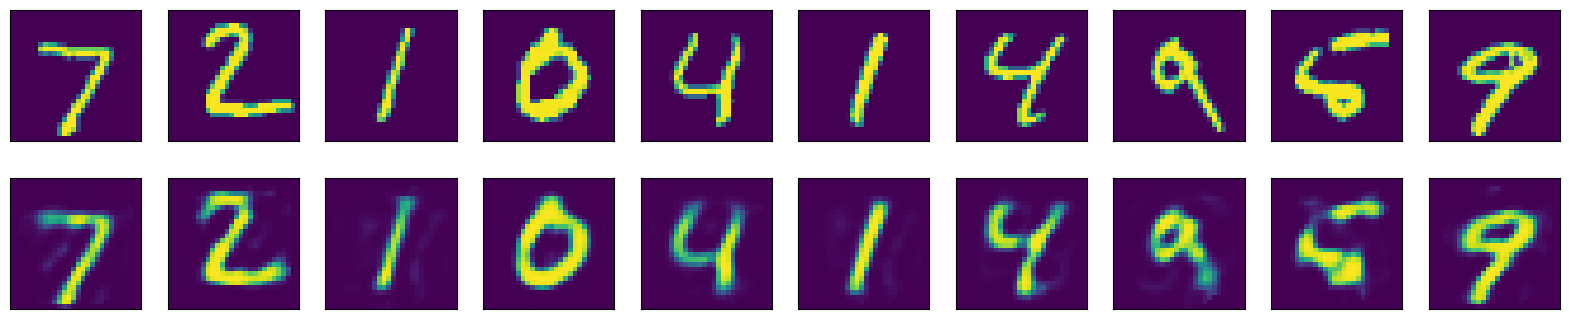

In [24]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


#  **Denoising AutoEncoder**

Denoising is one of the classic applications of autoencoders. The denoising process removes unwanted noise that corrupted the true signal.
Noise + Data ----> Denoising Autoencoder ----> Data.
Given a training dataset of corrupted data as input and true signal as output, a denoising autoencoder can recover the hidden structure to generate clean data. This example has modular design. The encoder, decoder and autoencoder are
3 models that share weights. For example, after training the autoencoder, the
encoder can be used to generate latent vectors of input data for low-dim visualization like PCA or TSNE.

Generate corrupted MNIST images by adding noise with normal distribution (mean = 0.0 and std= ) to your x_train and x_test dataset.

In [1]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)



After adding the random generated noises to the x sets, keep only those
among 0 and 1 using np.clip()/.

In [2]:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

it looks like

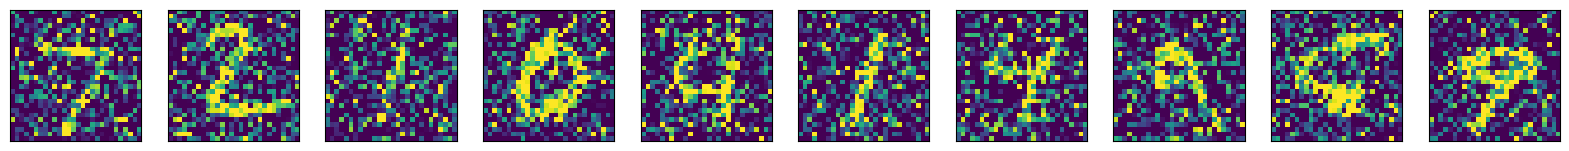

In [3]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Now build autoencoder to denoise images : use noised data in train to predict original images

In [9]:
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')

In [10]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 7, 7, 32)          9248

In [11]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/20
469/469 [==============================] - 15s 31ms/step - loss: 0.1612 - val_loss: 0.1162
Epoch 2/20
469/469 [==============================] - 15s 31ms/step - loss: 0.1120 - val_loss: 0.1073
Epoch 3/20
469/469 [==============================] - 15s 31ms/step - loss: 0.1062 - val_loss: 0.1038
Epoch 4/20
469/469 [==============================] - 15s 31ms/step - loss: 0.1035 - val_loss: 0.1025
Epoch 5/20
469/469 [==============================] - 15s 31ms/step - loss: 0.1019 - val_loss: 0.1000
Epoch 6/20
469/469 [==============================] - 15s 31ms/step - loss: 0.1007 - val_loss: 0.0991
Epoch 7/20
469/469 [==============================] - 15s 31ms/step - loss: 0.0998 - val_loss: 0.0984
Epoch 8/20
469/469 [==============================] - 14s 30ms/step - loss: 0.0990 - val_loss: 0.0976
Epoch 9/20
469/469 [==============================] - 14s 31ms/step - loss: 0.0984 - val_loss: 0.0971
Epoch 10/20
469/469 [==============================] - 14s 30ms/step - loss: 0.097

we compare now

313/313 [==============================] - 1s 3ms/step


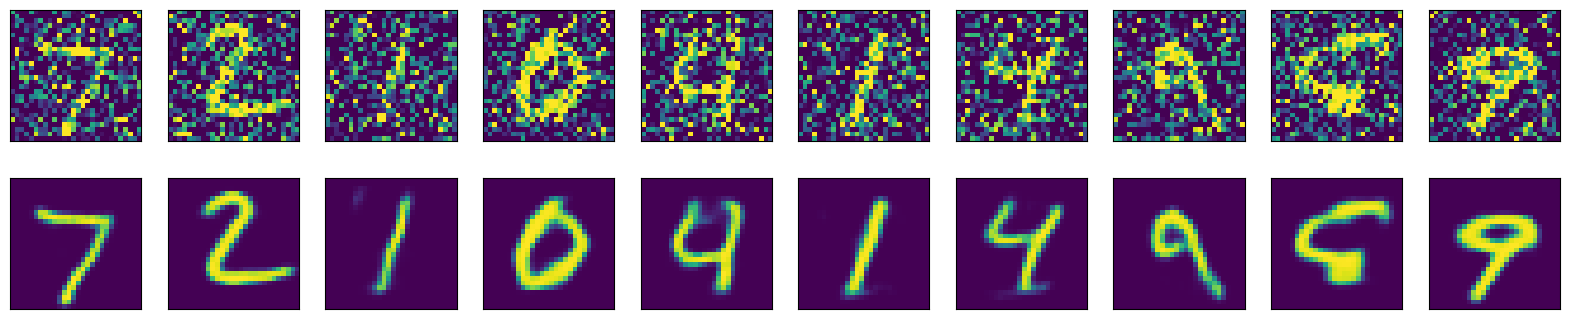

In [12]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i +1+ n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#  **ConvNet for AutoEncoder**





Exemple 2

In [24]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model


input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='nadam', loss='mse')



In [25]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/20
469/469 [==============================] - 9s 18ms/step - loss: 0.0540 - val_loss: 0.0340
Epoch 2/20
469/469 [==============================] - 9s 18ms/step - loss: 0.0288 - val_loss: 0.0252
Epoch 3/20
469/469 [==============================] - 8s 18ms/step - loss: 0.0232 - val_loss: 0.0217
Epoch 4/20
469/469 [==============================] - 8s 18ms/step - loss: 0.0206 - val_loss: 0.0191
Epoch 5/20
469/469 [==============================] - 9s 18ms/step - loss: 0.0192 - val_loss: 0.0184
Epoch 6/20
469/469 [==============================] - 9s 18ms/step - loss: 0.0181 - val_loss: 0.0174
Epoch 7/20
469/469 [==============================] - 9s 18ms/step - loss: 0.0174 - val_loss: 0.0168
Epoch 8/20
469/469 [==============================] - 9s 18ms/step - loss: 0.0167 - val_loss: 0.0164
Epoch 9/20
469/469 [==============================] - 8s 18ms/step - loss: 0.0162 - val_loss: 0.0154
Epoch 10/20
469/469 [==============================] - 9s 18ms/step - loss: 0.0156 - val_lo

313/313 [==============================] - 1s 3ms/step


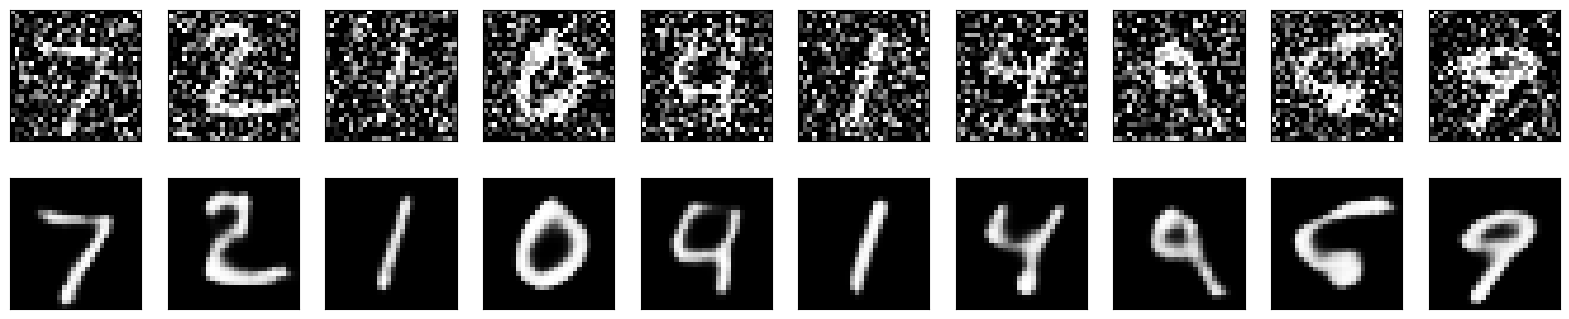

In [28]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i +1+ n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [29]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_55 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_56 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 7, 7, 8)           0         
 ng2D)                                                           
                                                                 
 conv2d_57 (Conv2D)          (None, 7, 7, 8)           584 

# **Variational AutoEncoder**

In [30]:
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras

In [31]:
#Create a sampling layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [32]:
#Build the encoder
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_62 (Conv2D)          (None, 14, 14, 32)           320       ['input_12[0][0]']            
                                                                                                  
 conv2d_63 (Conv2D)          (None, 7, 7, 64)             18496     ['conv2d_62[0][0]']           
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_63[0][0]']           
                                                                                            

In [33]:
#Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289 

In [34]:
# Define the VAE as a Model with a custom train_step

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [35]:
# Train the VAE

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)


Epoch 1/30
547/547 [==============================] - 13s 22ms/step - loss: 257.4398 - reconstruction_loss: 211.9653 - kl_loss: 1.9475
Epoch 2/30
547/547 [==============================] - 12s 22ms/step - loss: 190.5020 - reconstruction_loss: 186.0213 - kl_loss: 3.0029
Epoch 3/30
547/547 [==============================] - 15s 27ms/step - loss: 184.7528 - reconstruction_loss: 180.6402 - kl_loss: 3.2421
Epoch 4/30
547/547 [==============================] - 14s 26ms/step - loss: 180.0400 - reconstruction_loss: 173.6517 - kl_loss: 4.1652
Epoch 5/30
547/547 [==============================] - 14s 26ms/step - loss: 169.1905 - reconstruction_loss: 160.6274 - kl_loss: 5.5634
Epoch 6/30
547/547 [==============================] - 15s 27ms/step - loss: 160.9769 - reconstruction_loss: 154.2581 - kl_loss: 6.1424
Epoch 7/30
547/547 [==============================] - 14s 25ms/step - loss: 158.6451 - reconstruction_loss: 152.0349 - kl_loss: 6.2250
Epoch 8/30
547/547 [==============================] - 1

In [ ]:
# Display a grid of sampled digits

import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)


In [37]:

def plot_label_clusters(vae, data, labels):
    # Display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    # Define a colormap
    colormap = plt.cm.get_cmap("tab10", len(np.unique(labels)))
    # Plot each data point with a color corresponding to its label
    for label in np.unique(labels):
        indices = labels == label
        plt.scatter(z_mean[indices, 0], z_mean[indices, 1], c=colormap(label), label=label)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.legend()
    plt.show()

(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

1604/1875 [========================>.....] - ETA: 0s

KeyboardInterrupt: 

# **GAN**

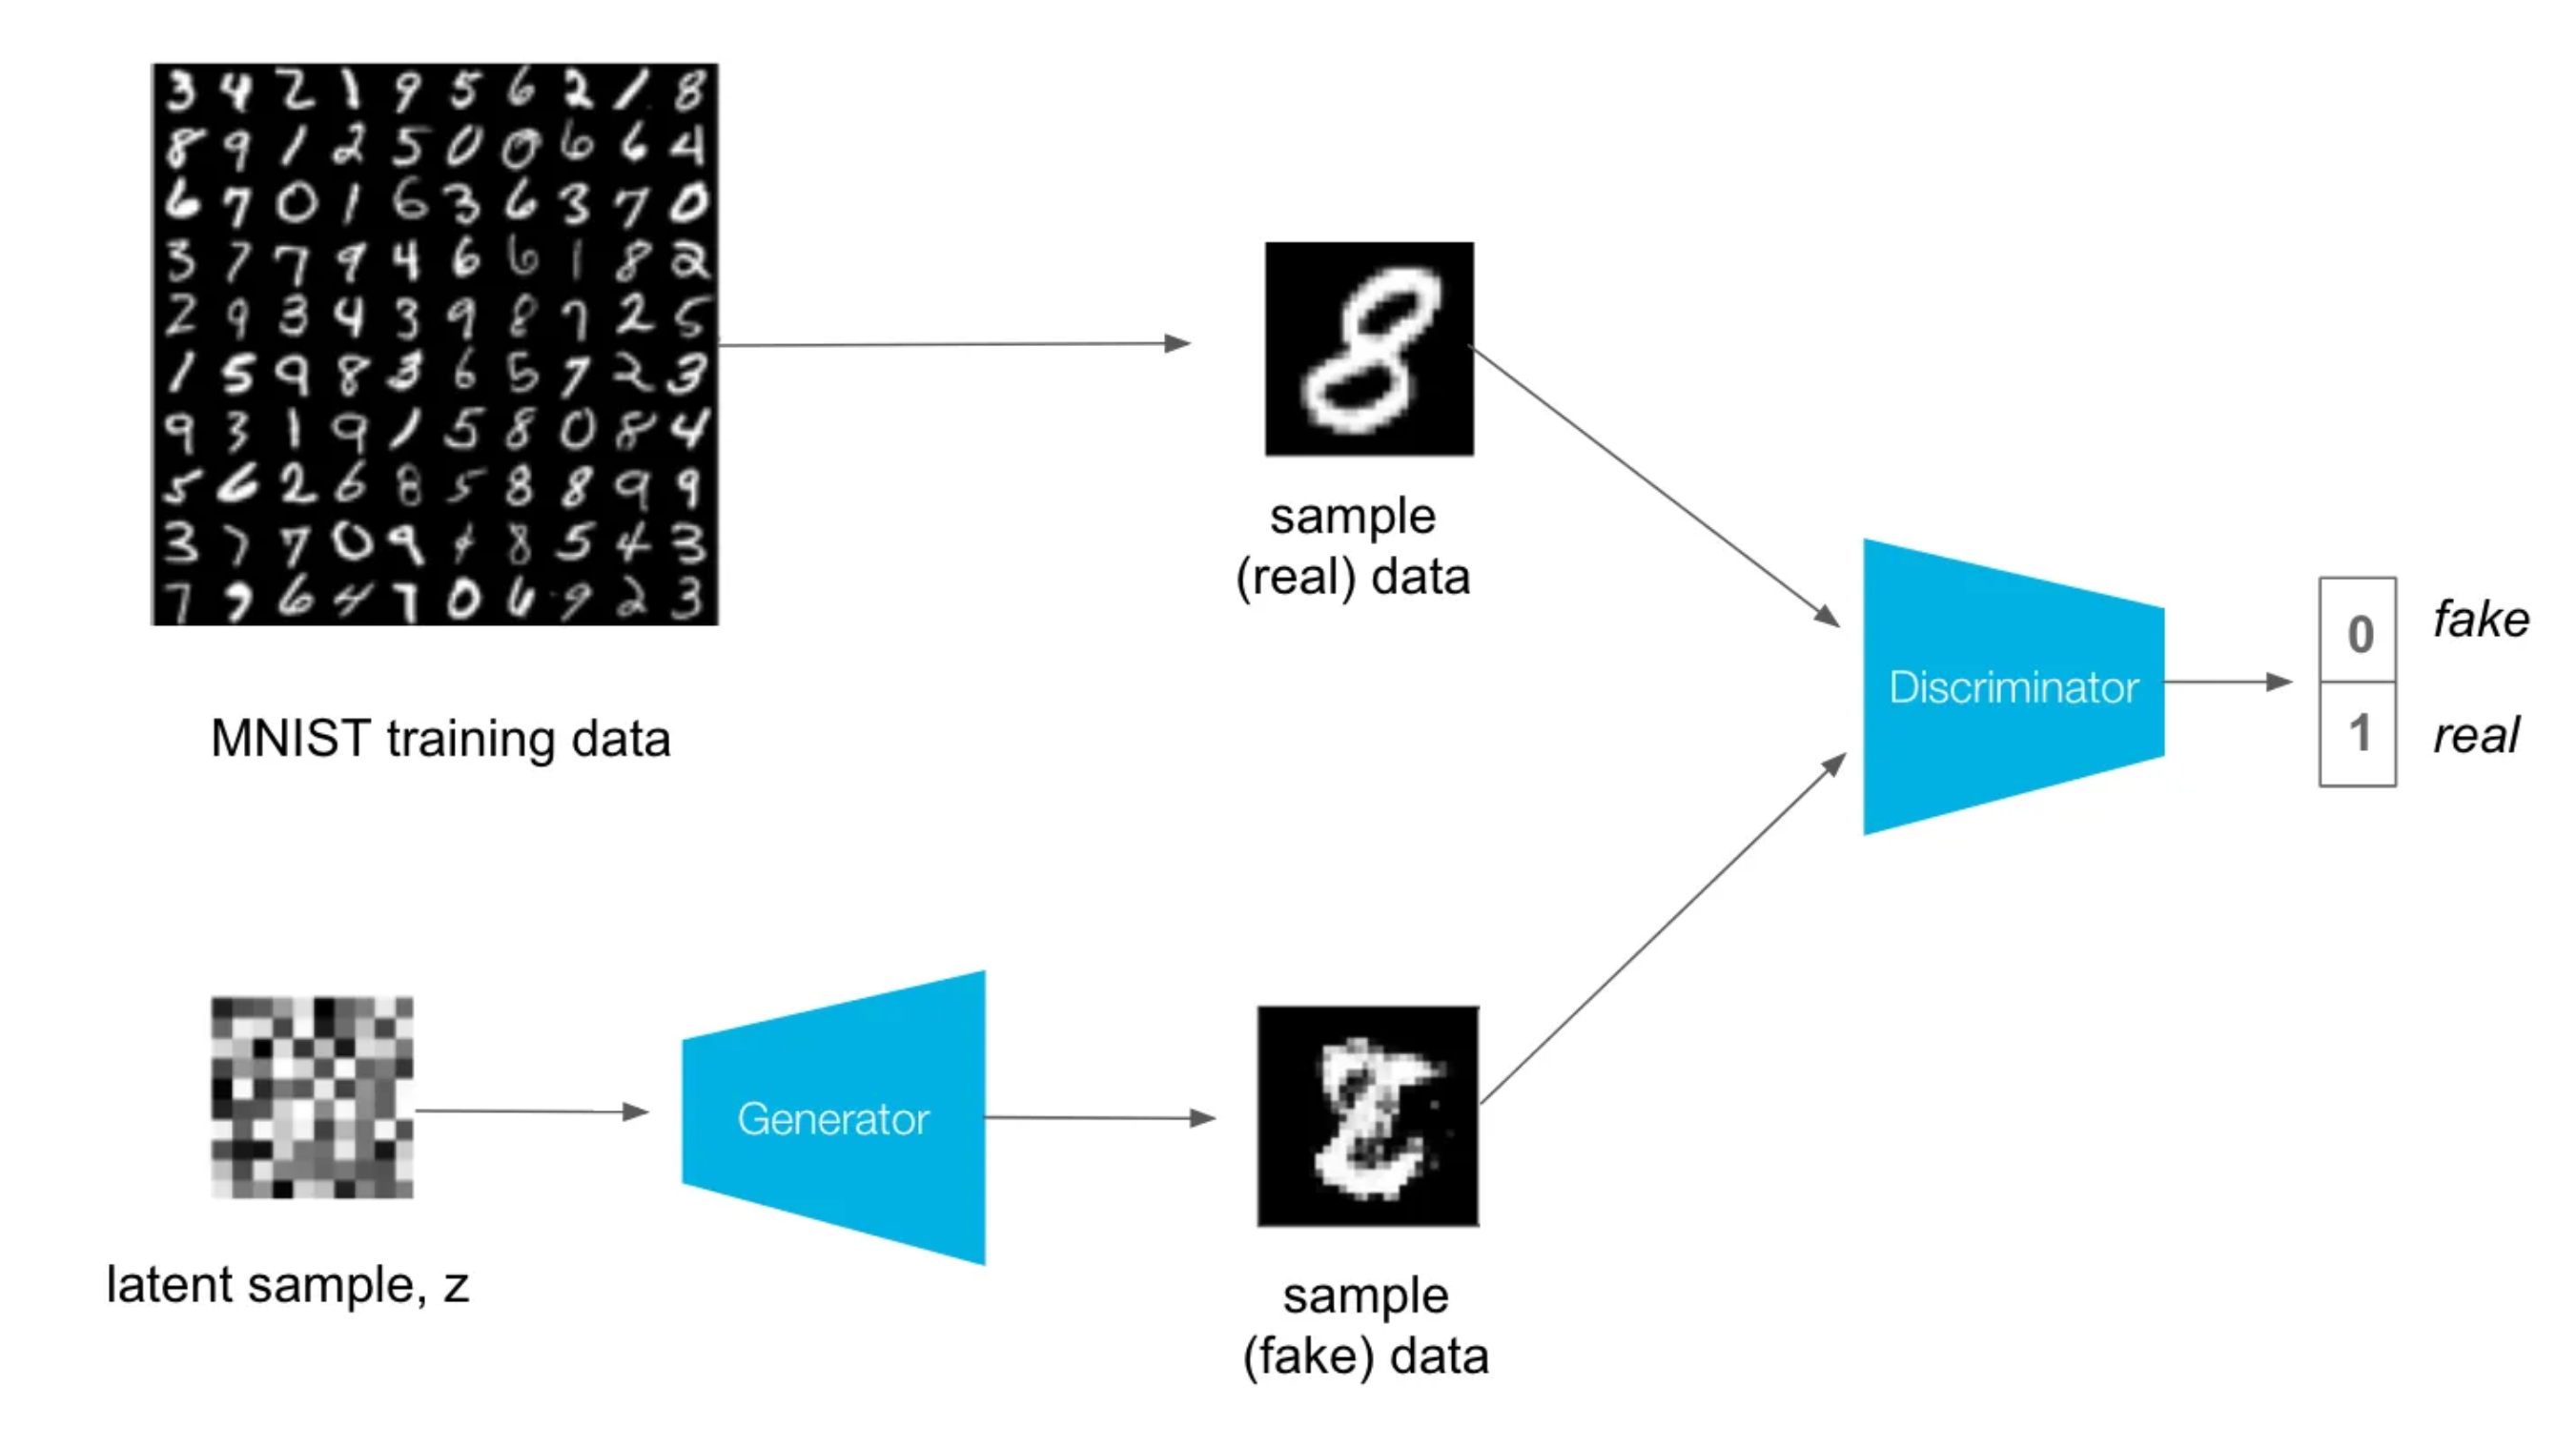

## Discriminator Model

The function define_discriminator() below defines the discriminator model and parametrizes the size of the input image.

In [1]:
# example of defining the discriminator model
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.datasets import mnist
from keras.utils import plot_model

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

## Running the example first summarizes the model architecture, showing the input and output from each layer.
# define model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




We can see that the aggressive 2×2 stride acts to down-sample the input image, first from 28×28 to 14×14, then to 7×7, before the model makes an output prediction.

This pattern is by design as we do not use pooling layers and use the large stride as achieve a similar downsampling effect. We will see a similar pattern, but in reverse, in the generator model in the next section.

We will use the mnist.load_data() function to load the MNIST dataset and just use the input part of the training dataset as the real images

*  The images are 2D arrays of pixels and convolutional neural networks expect 3D arrays of images as input, where each image has one or more channels.

*  We must update the images to have an additional dimension for the grayscale channel. We can do this using the expand_dims() NumPy function and specify the final dimension for the channels-last image format.

*  Finally, we must scale the pixel values from the range of unsigned integers in [0,255] to the normalized range of [0,1].

The load_real_samples() function below implements this.

In [2]:
# load and prepare mnist training images
def load_real_samples():
 # load mnist dataset
 (trainX, _), (_, _) = mnist.load_data()
 # expand to 3d, e.g. add channels dimension
 X = expand_dims(trainX, axis=-1)
 # convert from unsigned ints to floats
 X = X.astype('float32')
 # scale from [0,255] to [0,1]
 X = X / 255.0
 return X


The model will be updated in batches, specifically with a collection of real samples and a collection of generated samples. On training, epoch is defined as one pass through the entire training dataset.

We could systematically enumerate all samples in the training dataset, and that is a good approach, but good training via stochastic gradient descent requires that the training dataset be shuffled prior to each epoch. A simpler approach is to select random samples of images from the training dataset.

The generate_real_samples() function below will take the training dataset as an argument and will select a random subsample of images; it will also return class labels for the sample, specifically a class label of 1, to indicate real images.

In [3]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

Now, we need a source of fake images.

We don’t have a generator model yet, so instead, we can generate images comprised of random pixel values, specifically random pixel values in the range [0,1] like our scaled real images.

The generate_fake_samples() function below implements this behavior and generates images of random pixel values and their associated class label of 0, for fake.

In [4]:
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

Finally, we need to train the discriminator model.

This involves repeatedly retrieving samples of real images and samples of generated images and updating the model for a fixed number of iterations.

We will ignore the idea of epochs for now (e.g. complete passes through the training dataset) and fit the discriminator model for a fixed number of batches. The model will learn to discriminate between real and fake (randomly generated) images rapidly, therefore, not many batches will be required before it learns to discriminate perfectly.

The train_discriminator() function implements this, using a batch size of 256 images where 128 are real and 128 are fake each iteration.

We update the discriminator separately for real and fake examples so that we can calculate the accuracy of the model on each sample prior to the update. This gives insight into how the discriminator model is performing over time

In [5]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

Running the example first defines the model, loads the MNIST dataset, then trains the discriminator model.

In [6]:
# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

11490434/11490434 [==============================] - 0s 0us/step
>1 real=31% fake=43%
>2 real=52% fake=65%
>3 real=39% fake=76%
>4 real=41% fake=92%
>5 real=45% fake=94%
>6 real=39% fake=97%
>7 real=48% fake=100%
>8 real=57% fake=100%
>9 real=43% fake=99%
>10 real=45% fake=100%
>11 real=42% fake=100%
>12 real=41% fake=100%
>13 real=57% fake=100%
>14 real=56% fake=100%
>15 real=52% fake=100%
>16 real=63% fake=100%
>17 real=59% fake=100%
>18 real=70% fake=100%
>19 real=67% fake=100%
>20 real=72% fake=100%
>21 real=73% fake=100%
>22 real=71% fake=100%
>23 real=91% fake=100%
>24 real=86% fake=100%
>25 real=88% fake=100%
>26 real=88% fake=100%
>27 real=96% fake=100%
>28 real=97% fake=100%
>29 real=97% fake=100%
>30 real=95% fake=100%
>31 real=98% fake=100%
>32 real=99% fake=100%
>33 real=98% fake=100%
>34 real=100% fake=100%
>35 real=100% fake=100%
>36 real=100% fake=100%
>37 real=100% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>40 real=100% fake=100%
>41 real=100% fake=100%


## Generator Model

Now that we know how to define and train the discriminator model, we need to look at developing the generator model.

The generator model is responsible for creating new, fake but plausible images of handwritten digits.

It does this by taking a point from the latent space as input and outputting a square grayscale image

The latent space is an arbitrarily defined vector space of Gaussian-distributed values, e.g. 100 dimensions. It has no meaning, but by drawing points from this space randomly and providing them to the generator model during training, the generator model will assign meaning to the latent points and, in turn, the latent space, until, at the end of training, the latent vector space represents a compressed representation of the output space, MNIST images, that only the generator knows how to turn into plausible MNIST images.

    Inputs: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.
    Outputs: Two-dimensional square grayscale image of 28×28 pixels with pixel values in [0,1].

Note: we don’t have to use a 100 element vector as input; it is a round number and widely used, but I would expect that 10, 50, or 500 would work just as well.

Developing a generator model requires that we transform a vector from the latent space with, 100 dimensions to a 2D array with 28×28 or 784 values.

There are a number of ways to achieve this but there is one approach that has proven effective at deep convolutional generative adversarial networks. It involves two main elements.

*  The first is a Dense layer as the first hidden layer that has enough nodes to represent a low-resolution version of the output image. Specifically, an image half the size (one quarter the area) of the output image would be 14×14 or 196 nodes, and an image one quarter the size (one eighth the area) would be 7×7 or 49 nodes.

*  We don’t just want one low-resolution version of the image; we want many parallel versions or interpretations of the input. This is a pattern in convolutional neural networks where we have many parallel filters resulting in multiple parallel activation maps, called feature maps, with different interpretations of the input. We want the same thing in reverse: many parallel versions of our output with different learned features that can be collapsed in the output layer into a final image. The model needs space to invent, create, or generate.

Therefore, the first hidden layer, the Dense, needs enough nodes for multiple low-resolution versions of our output image, such as 128

In [7]:
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
 # We will use the LeakyReLU with a default slope of 0.2, reported as a best practice when training GAN models.
	model.add(LeakyReLU(alpha=0.2))
 # The activations from these nodes can then be reshaped into something image-like to pass into a convolutional layer, such as 128 different 7×7 feature maps
	model.add(Reshape((7, 7, 128)))
 ###******####
# There are two common ways to do this upsampling process, sometimes called deconvolution.
# One way is to use an UpSampling2D layer (like a reverse pooling layer) followed by a normal Conv2D layer.
# The other and perhaps more modern way is to combine these two operations into a single layer, called a Conv2DTranspose.
# We will use this latter approach for our generator.
# The Conv2DTranspose layer can be configured with a stride of (2×2) that will quadruple the area of the input feature maps (double their width and height dimensions).
# It is also good practice to use a kernel size that is a factor of the stride (e.g. double) to avoid a checkerboard pattern that can be observed when upsampling.
###******####
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

Running the example summarizes the layers of the model and their output shape.

In [8]:
# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

We can see that, as designed, the first hidden layer has 6,272 parameters or 128 * 7 * 7, the activations of which are reshaped into 128 7×7 feature maps. The feature maps are then upscaled via the two Conv2DTranspose layers to the desired output shape of 28×28, until the output layer, where a single activation map is output.

This model cannot do much at the moment.

Nevertheless, we can demonstrate how to use it to generate samples. This is a helpful demonstration to understand the generator as just another model, and some of these elements will be useful later.

*  The first step is to generate new points in the latent space. We can achieve this by calling the randn() NumPy function for generating arrays of random numbers drawn from a standard Gaussian.


*  We can update the generate_fake_samples() function from the previous section to take the generator model as an argument and use it to generate the desired number of samples by first calling the generate_latent_points() function to generate the required number of points in latent space as input to the model.

In [9]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
 # generate points in the latent space
 x_input = randn(latent_dim * n_samples)
 # reshape into a batch of inputs for the network
 x_input = x_input.reshape(n_samples, latent_dim)
 return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
 # generate points in latent space
 x_input = generate_latent_points(latent_dim, n_samples)
 # predict outputs
 X = g_model.predict(x_input)
 # create 'fake' class labels (0)
 y = zeros((n_samples, 1))
 return X, y

We can use the latent sapce to generate new points next we can use the generated points as input to the generator model to generate new samples, then plot the samples.

Running the example generates 25 examples of fake MNIST images and visualizes them on a single plot of 5 by 5 images.

1/1 [==============================] - 0s 255ms/step


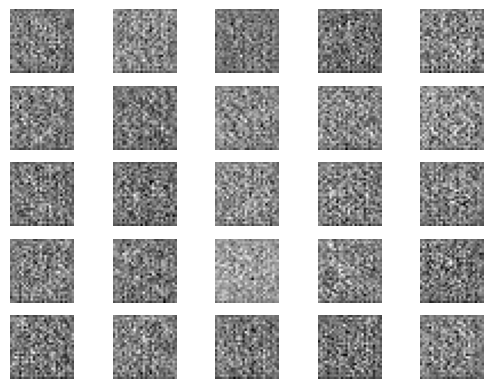

In [10]:
from numpy.random import randn
from matplotlib import pyplot
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
 # define subplot
 pyplot.subplot(5, 5, 1 + i)
 # turn off axis labels
 pyplot.axis('off')
 # plot single image
 pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
pyplot.show()

## GAN

The weights in the generator model are updated based on the performance of the discriminator model.

When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less

This defines the zero-sum or adversarial relationship between these two models.

There may be many ways to implement this using the Keras API, but perhaps the simplest approach is to create a new model that combines the generator and discriminator models.

Specifically, a new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space and generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

To be clear, we are not talking about a new third model, just a new logical model that uses the already-defined layers and weights from the standalone generator and discriminator models.

Only the discriminator is concerned with distinguishing between real and fake examples, therefore the discriminator model can be trained in a standalone manner on examples of each, as we did in the section on the discriminator model above.

The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.

When training the generator via this logical GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1)

**Why would we want to do this?**


We can imagine that the discriminator will then classify the generated samples as not real (class 0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating good fake samples.

Let’s make this concrete.

*  Inputs: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.
*  Outputs: Binary classification, likelihood the sample is real (or fake).

The define_gan() function below takes as arguments the already-defined generator and discriminator models and creates the new logical third model subsuming these two models. The weights in the discriminator are marked as not trainable, which only affects the weights as seen by the GAN model and not the standalone discriminator model.

The GAN model then uses the same binary cross entropy loss function as the discriminator and the efficient Adam version of stochastic gradient descent with the learning rate of 0.0002 and momentum 0.5, recommended when training deep convolutional GANs.

In [11]:
def define_gan(g_model, d_model):
 # make weights in the discriminator not trainable
 d_model.trainable = False
 # connect them
 model = Sequential()
 # add generator
 model.add(g_model)
 # add the discriminator
 model.add(d_model)
 # compile model
 opt = Adam(lr=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt)
 return model

Running the example first creates a summary of the composite model.

In [12]:

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 40705     
                                                                 
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


We can see that the model expects MNIST images as input and predict a single value as output.

Training the composite model involves generating a batch worth of points in the latent space via the generate_latent_points() function in the previous section, and class=1 labels and calling the train_on_batch() function.

The train_gan() function below demonstrates this, although is pretty simple as only the generator will be updated each epoch, leaving the discriminator with default model weights

In [13]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

Instead, what is required is that we first update the discriminator model with real and fake samples, then update the generator via the composite model.

This requires combining elements from the train_discriminator() function defined in the discriminator section above and the train_gan() function defined above. It also requires that we enumerate over both epochs and batches within in an epoch.

The complete train function for updating the discriminator model and the generator (via the composite model) is listed below.

There are a few things to note in this model training function.

First, the number of batches within an epoch is defined by how many times the batch size divides into the training dataset. We have a dataset size of 60K samples, so with rounding down, there are 234 batches per epoch.

The discriminator model is updated once per batch by combining one half a batch of fake and real examples into a single batch via the vstack() NumPy function. You could update the discriminator with each half batch separately (recommended for more complex datasets) but combining the samples into a single batch will be faster over a long run, especially when training on GPU hardware.

Finally, we report the loss each batch. It is critical to keep an eye on the loss over batches. The reason for this is that a crash in the discriminator loss indicates that the generator model has started generating rubbish examples that the discriminator can easily discriminate.

Monitor the discriminator loss and expect it to hover around 0.5 to 0.8 per batch on this dataset. The generator loss is less critical and may hover between 0.5 and 2 or higher on this dataset. A clever programmer might even attempt to detect the crashing loss of the discriminator, halt, and then restart the training process.

In [14]:
# train the generator and discriminator
from numpy import vstack
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

How to Evaluate GAN Model Performance

Generally, there are no objective ways to evaluate the performance of a GAN model.

We cannot calculate this objective error score for generated images. It might be possible in the case of MNIST images because the images are so well constrained, but in general, it is not possible (yet).

Instead, images must be subjectively evaluated for quality by a human operator. This means that we cannot know when to stop training without looking at examples of generated images. In turn, the adversarial nature of the training process means that the generator is changing after every batch, meaning that once “good enough” images can be generated, the subjective quality of the images may then begin to vary, improve, or even degrade with subsequent updates.

There are three ways to handle this complex training situation.

*  Periodically evaluate the classification accuracy of the discriminator on real and fake images.
*  Periodically generate many images and save them to file for subjective review.
*  Periodically save the generator model.

All three of these actions can be performed at the same time for a given training epoch, such as every five or 10 training epochs. The result will be a saved generator model for which we have a way of subjectively assessing the quality of its output and objectively knowing how well the discriminator was fooled at the time the model was saved.

Training the GAN over many epochs, such as hundreds or thousands of epochs, will result in many snapshots of the model that can be inspected and from which specific outputs and models can be cherry-picked for later use.


First, The generator model can be saved by calling the save() function on the generator model and providing a unique filename based on the training epoch numbe

In [15]:
# save the generator model tile file
# filename = 'generator_model_%03d.h5' % (epoch + 1)
# g_model.save(filename)

We can develop a function to create a plot of the generated samples.

As we are evaluating the discriminator on 100 generated MNIST images, we can plot all 100 images as a 10 by 10 grid. The save_plot() function below implements this, again saving the resulting plot with a unique filename based on the epoch number.

In [16]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

we can define a function called summarize_performance() function that will summarize the performance of the discriminator model. It does this by retrieving a sample of real MNIST images, as well as generating the same number of fake MNIST images with the generator model, then evaluating the classification accuracy of the discriminator model on each sample and reporting these scores.   summarize_performance() function can  save the model and to create and save a plot generated examples.

In [17]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

Next, we can update `train()` function the to include the `summarize_performance()` function

In [18]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

We now have everything we need to train and evaluate a GAN on the MNIST handwritten digit dataset.

In [19]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

4/4 [==============================] - 0s 7ms/step
>1, 1/234, d=0.691, g=0.726
4/4 [==============================] - 0s 5ms/step
>1, 2/234, d=0.686, g=0.742
4/4 [==============================] - 0s 6ms/step
>1, 3/234, d=0.678, g=0.760
4/4 [==============================] - 0s 5ms/step
>1, 4/234, d=0.669, g=0.771
4/4 [==============================] - 0s 6ms/step
>1, 5/234, d=0.668, g=0.783
4/4 [==============================] - 0s 4ms/step
>1, 6/234, d=0.659, g=0.799
4/4 [==============================] - 0s 5ms/step
>1, 7/234, d=0.650, g=0.813
4/4 [==============================] - 0s 5ms/step
>1, 8/234, d=0.652, g=0.823
4/4 [==============================] - 0s 5ms/step
>1, 9/234, d=0.645, g=0.828
4/4 [==============================] - 0s 5ms/step
>1, 10/234, d=0.641, g=0.834
4/4 [==============================] - 0s 5ms/step
>1, 11/234, d=0.644, g=0.826
4/4 [==============================] - 0s 6ms/step
>1, 12/234, d=0.647, g=0.808
4/4 [==============================] - 0s 5ms/ste

Once a final generator model is selected, it can be used in a standalone manner for your application.

This involves first loading the model from file, then using it to generate images. The generation of each image requires a point in the latent space as input.

The complete example of loading the saved model and generating images is listed below. In this case, we will use the model saved after 100 training epochs, but the model saved after 40 or 50 epochs would work just as well.

Running the example first loads the model, samples 25 random points in the latent space, generates 25 images, then plots the results as a single image.

1/1 [==============================] - 0s 200ms/step


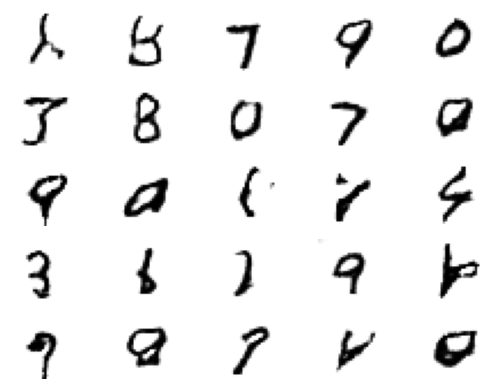

In [20]:
# create and save a plot of generated images (reversed grayscale)
from keras.models import load_model
def save_plot_g(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('generator_model_050.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot_g(X, 5)

We can see that most of the images are plausible, or plausible pieces of handwritten digits.

In [21]:
latent_points[1]

array([ 0.41100587, -1.79359252, -0.10451395, -1.01479762, -1.43385418,
       -0.51687281,  0.71433582, -0.40200885,  0.84897482,  0.41548065,
        1.02940867,  0.14161574,  0.98347859,  0.11842318, -1.64485017,
        1.2174325 , -0.20220628,  1.30269225, -0.08866513,  0.25080655,
        1.47621263, -0.64687678, -0.21632287,  0.259268  ,  2.89389694,
        2.1129057 ,  0.73687028,  0.66989747,  0.18019988,  0.49757163,
        1.47815648,  0.16610915,  0.04003448,  1.00957408, -0.57732236,
        0.31863944,  0.30089202,  1.20254723, -0.437283  ,  1.15529355,
       -0.53300849, -0.80998543,  0.47326681, -1.92937497, -0.82139717,
        0.73085669,  0.37086217, -1.12595079,  0.14623731,  1.58036136,
       -0.98341174, -0.20182589, -1.79015893,  0.8367336 ,  0.42762089,
       -1.04557674, -0.54039438,  0.82121875,  1.76439672, -0.46651603,
        1.3202902 ,  0.72401656,  1.63105428, -0.04153989, -0.11051556,
        0.66648581, -0.05538181,  0.57505757, -1.99437291,  0.85

You can experiment with generating different points in this space and see what types of numbers they generate.

The example below generates a single handwritten digit using a vector of all 0.0 values.

1/1 [==============================] - 0s 250ms/step


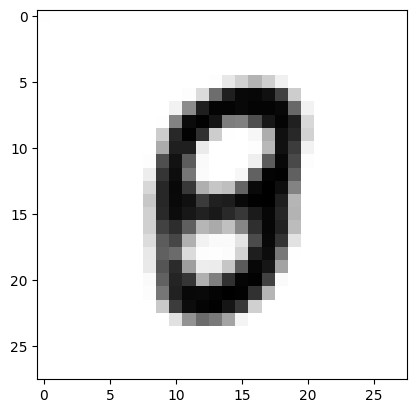

In [22]:
# example of generating an image for a specific point in the latent space
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
# load model
model = load_model('generator_model_050.h5')
# all 0s
vector = asarray([[0.0 for _ in range(100)]])
# generate image
X = model.predict(vector)
# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()